# Final Proteomics Pipeline - Package

## 0. Setup
- Import your package, e.g. `import proteosim as ps`.
- Set random/Numpy seeds for reproducibility.

In [1]:
import proteosim as ps
import random
import numpy as np
import pandas as pd
np.random.seed(42)

random.seed(...)

/var/folders/hw/7nxjpy9j5gsdlpsc34n1q7gc0000gn/T/ipykernel_2514/2082162796.py:7: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(...)


## 1. FASTA input - read_fasta
- Input: `data/sample_proteins.fasta`.
- Output: protein_id -> protein_sequence dictionary via `ps.read_fasta`.

In [2]:
protein_map = ps.read_fasta("data/sample_proteins.fasta")
len(protein_map)

3

## 2. Protein digestion
- Choose protease (manually or if saved within module call `enzyme_cleavage_patterns`).
- Input: `protein_map`
- Output: `digested_peptides_map`.
- Optional: coverage stats via `ps.compute_sequence_coverage`.

In [3]:
cleave_pattern = ps.enzyme_cleavage_patterns["Trypsin"] # Choose Trypsin
cleave_pattern

'(?<=[KR])(?!P)'

In [4]:
digested_peptides_map = ps.digest_protein_collection(protein_map, cleave_pattern)
digested_peptides_map

{'P11802': ['MATSR',
  'YEPVAEIGVGAYGTVYK',
  'DPHSGHFVALK',
  'VPNGGGGGGGLPISTVR',
  'EVALLR',
  'LEAFEHPNVVR',
  'LMDVCATSR',
  'VTLVFEHVDQDLR',
  'TYLDK',
  'APPPGLPAETIK',
  'GLDFLHANCIVHR',
  'DLKPENILVTSGGTVK',
  'LADFGLAR',
  'IYSYQMALTPVVVTLWYR',
  'APEVLLQSTYATPVDMWSVGCIFAEMFR',
  'KPLFCGNSEADQLGK',
  'IFDLIGLPPEDDWPR',
  'DVSLPR',
  'GAFPPR',
  'GPRPVQSVVPEMEESGAQLLLEMLTFNPHK',
  'ISAFR',
  'ALQHSYLHK',
  'DEGNPE'],
 'A0A087WTH1': ['MEDEEK',
  'AVEILGNTEAAHPPSPIR',
  'CCWLR',
  'CLAATSIICGCSCLGVMALVFAIK',
  'SEEAVR'],
 'A0A087WTH5': ['MVIEWERPR',
  'MILSNTTAVTPFLTK',
  'LWQETVQQGGNMSGLAR',
  'SGDGK',
  'LEALYVLMVLGFFGFFTLGIMLSYIR',
  'LEHSNDPFNVYIESNAWQEK',
  'AYVQAR',
  'VLESYR',
  'SCYVVENHLAIEQPNTHLPETKPSP']}

In [5]:
# Compute per protein coverage
for prot, peps in digested_peptides_map.items():

    coverage = ps.compute_sequence_coverage(
        protein_seq=protein_map[prot],
        peptides=peps,
        )

    print(f'{prot}: {coverage}')

P11802: 92.73927392739274
A0A087WTH1: 50.86206896551724
A0A087WTH5: 93.47826086956522


## 3. Liquid chromatography simulation
- Pool peptides and predict retention times.
- Plot histogram via `ps.plot_retention_time`.
- Select retention window with `ps.select_retention_time_window`.

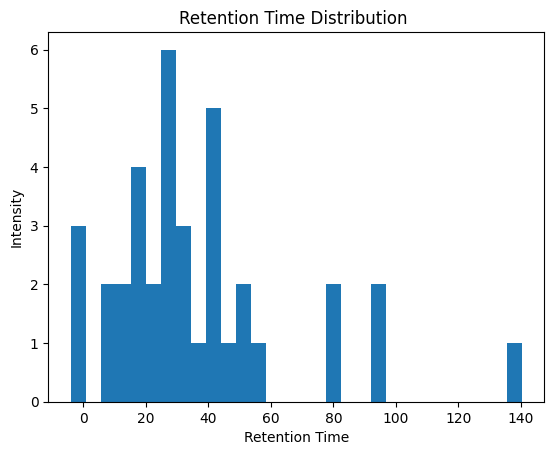

In [6]:
pooled_peps = [pep for peptides in digested_peptides_map.values() for pep in peptides]
rt_map = ps.predict_lc_retention_times(pooled_peps)
ps.plot_retention_time(rt_map.values(), resolution=30)
select_peps = select_peps = ps.select_retention_time_window(
    peptide_rt_map=rt_map,
    lower_ret_time=0,
    upper_ret_time=20,
)

## 4. MS1 simulation
- Masses: `ps.calculate_mol_mass_collection`.
- m/z: `ps.calculate_mz_collection` with charge=2.
- Plot: `ps.plot_ms1`.

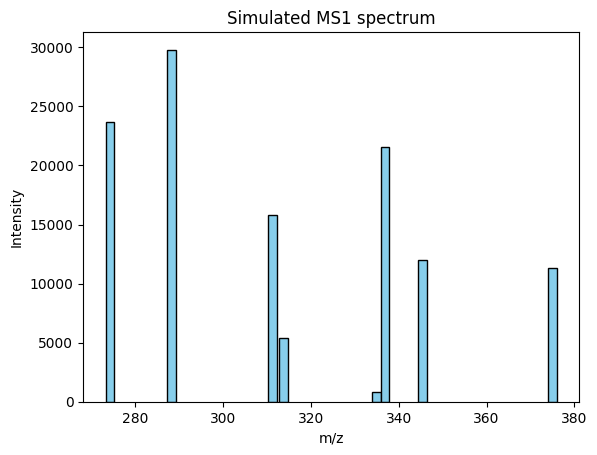

In [7]:
mass_map_ms1 = ps.calculate_mol_mass_collection(select_peps, ps.amino_acid_mass_dalton)
mz1_map = ps.calculate_mz_collection(mass_map_ms1)
ps.plot_spectrum(mz1_map.values(), random_count_range=(0, 30000), seed=42,title="Simulated MS1 spectrum")

## 5. MS2 simulation
- Choose peptide `MATSR`).
- Fragments: `ps.fragment_peptide`.
- Masses/m/z with charge=1.
- Plot reused MS1 helper.

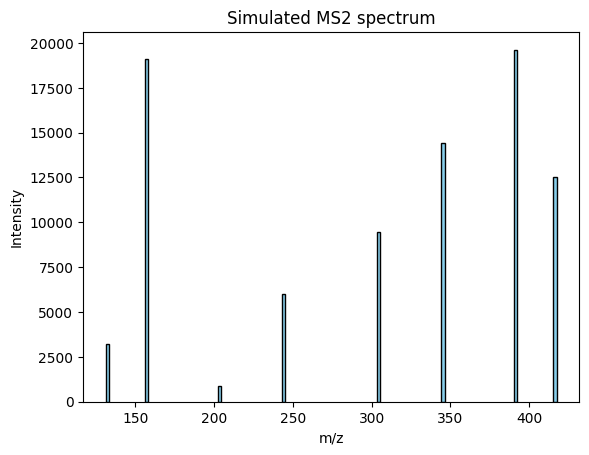

In [8]:
mypep = 'MATSR'
frags = ps.fragment_peptide(mypep)
mass_map_ms2 = ps.calculate_mol_mass_collection(frags, ps.amino_acid_mass_dalton)
mz2_map = ps.calculate_mz_collection(mass_map_ms2, charge=1)
ps.plot_spectrum(mz2_map.values(), random_count_range=(0, 20000), seed=1337, title="Simulated MS2 spectrum")

## 6. Export results
- Save MS1 TSV.
- Save MS2 TSV.
- Document file paths for peer comparison.

> ❗ **Output naming**
> 
> Consider naming the output differently when saving results of notebook execution using your peers package or when using new input or parameters.

In [10]:
ms1_df = pd.DataFrame({'peptide': list(mz1_map.keys()), 'mz': list(mz1_map.values())})
ms1_df.to_csv('results/ms1_peptide_mzs.tsv', sep='	', index=False)

ms2_df = pd.DataFrame({'fragment': list(mz2_map.keys()), 'mz': list(mz2_map.values())})
ms2_df.to_csv('results/ms2_MATSR_fragment_mzs.tsv', sep='	', index=False)